In [23]:
import pandas as pd
import re
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt

In [24]:
# Function to fetch HTML content from a given URL
def get_html(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.content, "html.parser")
    return soup

# Function to extract reviews from a BeautifulSoup object
def extract_reviews(soup):
    reviews = []
    review_blocks = soup.find_all('div', {'class': '_27M-vq'})
    
    for block in review_blocks:
        review_element = block.find('p', {'class': '_2-N8zT'})
        review = review_element.text.strip()
        reviews.append(review)
    return reviews

def last_page(soup):
    page_block = soup.find_all('div', {'class': '_2MImiq _1Qnn1K'})
    page_block = page_block[0].find('span').text.strip()
    total_page = page_block.split('of')[1].strip()
    return int(total_page.replace(",", ""))


In [25]:

# URL of the page to scrape

# site_url = input("Enter FLIPKART product URL: ")
site_url="https://www.flipkart.com/gopro-hero-10-waterproof-front-lcd-touch-rear-screens-5-3k60-ultra-hd-video-1080p-live-streaming-webcam-stabilization-sports-action-camera/p/itm5f1f138a6cc3e?pid=SAYG7UB7MGZ89YNJ&lid=LSTSAYG7UB7MGZ89YNJGVR4G1&marketplace=FLIPKART&q=camera&store=jek%2Fp31&srno=s_1_5&otracker=search&otracker1=search&fm=search-autosuggest&iid=1ff28de9-e5dd-4e1a-b952-ab1dfc309343.SAYG7UB7MGZ89YNJ.SEARCH&ppt=sp&ppn=sp&ssid=g9ngqwo59s0000001705257860795&qH=dd6d2dcc679d12b9"

separator="marketplace=FLIPKART"
url = site_url.split(separator,1)[0] + separator
url = url.replace('/p/', '/product-reviews/')

reviews = []
page = 1
soup = get_html(url)
page_limit = last_page(soup)
scraped_pages = []

# Scraping pages
print(">>scraping pages : ")
while page <=  page_limit :
    page_url = url + "&page=" + str(page)
    scraped_pages.append(str(page))
    print(",".join(scraped_pages), end='\r')
    soup = get_html(page_url)
    page_reviews = extract_reviews(soup)
    reviews.extend(page_reviews)
    page += 1

print(",".join(scraped_pages))
print(">>scraping complete")
print(reviews[:10])

>>scraping pages : 
1,2,3,4,5,6
>>scraping complete
['Really Nice', 'Useless product', 'Highly recommended', 'Mind-blowing purchase', 'Excellent', 'Decent product', 'Not good', 'Classy product', 'Unsatisfactory', 'Expected a better product']


In [26]:
# Split reviews into sentences
string_value = ".".join(map(str, reviews))
separated_data= re.split('[,.!]', string_value)
separated_data = [x.strip() for x in separated_data if x.strip()]

# Remove emojis from the data
emoji_free_data = []


def replace_emoji_space(string):
    emoji_pattern = re.compile("["
                            "\U0001F1E0-\U0001F1FF"  # flags (iOS)
                            "\U0001F300-\U0001F5FF"  # symbols & pictographs
                            "\U0001F600-\U0001F64F"  # emoticons
                            "\U0001F680-\U0001F6FF"  # transport & map symbols
                            "\U0001F700-\U0001F77F"  # alchemical symbols
                            "\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
                            "\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                            "\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                            "\U0001FA00-\U0001FA6F"  # Chess Symbols
                            "\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                            "\U00002702-\U000027B0"  # Dingbats
                            "\U000024C2-\U0001F251"
                       "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r' ', str(string))
for i in separated_data:
    emoji_free_data.append(replace_emoji_space(i))

print(emoji_free_data[:10])

['Really Nice', 'Useless product', 'Highly recommended', 'Mind-blowing purchase', 'Excellent', 'Decent product', 'Not good', 'Classy product', 'Unsatisfactory', 'Expected a better product']


In [27]:
# Create a DataFrame from the cleaned data
review_df = pd.DataFrame(emoji_free_data, columns=['Reviews'])
review_df.head()

# Fill empty strings with 'Average'
review_df = review_df.replace(r'^\s*$', "Average", regex=True)

# Convert to lowercase
review_df["Reviews"] = review_df["Reviews"].str.lower()
print(review_df.head())
print('DataFrame length: ' + str(len(review_df)))


                 Reviews
0            really nice
1        useless product
2     highly recommended
3  mind-blowing purchase
4              excellent
DataFrame length: 36


In [28]:
# Load positive and negative words from files
file1 = "positiveword.txt"
positive_words = []
with open(file1, 'r') as file:
    for line in file:
        positive_words.append(line.strip().split(","))
print(positive_words[:10])

file2 = "negativeword.txt"
negative_words = []
with open(file2, 'r') as file:
    for line in file:
        negative_words.append(line.strip().split(","))
print(negative_words[:10])

[['a+'], ['abound'], ['abounds'], ['abundance'], ['abundant'], ['accessable'], ['accessible'], ['acclaim'], ['acclaimed'], ['acclamation']]
[['abnormal'], ['abolish'], ['abominable'], ['abominably'], ['abominate'], ['abomination'], ['abort'], ['aborted'], ['aborts'], ['abrade']]


In [29]:
# Copy the DataFrame for processing
review_dff = review_df.copy()

# Flatten the lists of positive and negative words
neg_flat_list = [item for sublist in negative_words for item in sublist]
print(neg_flat_list[:10])

pos_flat_list = [item for sublist in positive_words for item in sublist]
print(pos_flat_list[:10])


['abnormal', 'abolish', 'abominable', 'abominably', 'abominate', 'abomination', 'abort', 'aborted', 'aborts', 'abrade']
['a+', 'abound', 'abounds', 'abundance', 'abundant', 'accessable', 'accessible', 'acclaim', 'acclaimed', 'acclamation']


In [30]:
# Function to determine remarks (positive, negative, or average)
def determine_sentiment(review):
    review_words = set(review.lower().split())
    
    if any(word in review_words for word in neg_flat_list):
        return 'Negative'
    elif any(word in review_words for word in pos_flat_list):
        return 'Positive'
    else:
        return 'Average'

# Apply the determine_sentiment function to create the 'Remarks' column
review_dff['Sentiment'] = review_dff['Reviews'].apply(determine_sentiment)

print(review_dff.head(5))

                 Reviews Sentiment
0            really nice  Positive
1        useless product  Negative
2     highly recommended  Positive
3  mind-blowing purchase  Positive
4              excellent  Positive


In [31]:
# Count the occurrences of each Sentiment
sentiment_count = review_dff['Sentiment'].value_counts()
print(sentiment_count)

Sentiment
Positive    27
Negative     9
Name: count, dtype: int64


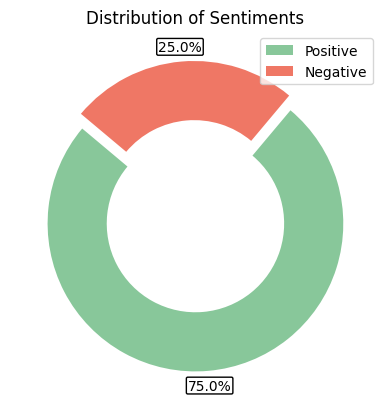

In [32]:
# Plot a pie chart to visualize the distribution of remarks
# explode = (0.05, 0.05, 0.05)
custom_colors = ['#88c79a', '#ef7765', '#6581c0']

# Determine the number of unique sentiments
num_sentiments = len(sentiment_count)

# Set explode based on the number of unique sentiments
explode = tuple(0.05 for _ in range(num_sentiments))

plt.pie(sentiment_count, autopct='%1.1f%%', startangle=140, colors=custom_colors,
        wedgeprops=dict(width=0.4), textprops={'color': 'black', 'bbox': {'facecolor': 'white', 'edgecolor': 'black', 'boxstyle': 'round,pad=0.1'}},
        pctdistance=1.1, explode=explode)

plt.title('Distribution of Sentiments')
plt.legend(sentiment_count.index, loc='upper right')
plt.show()